In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import time
import dwave_token
import neal
import dimod
import sklearn.metrics as skm

from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
from dwave.system import DWaveCliqueSampler
from dwave.system import LeapHybridCQMSampler

# automatically generated embedding:
# sampler = EmbeddingComposite(DWaveSampler(token=dwave_token.value))
# clique_sampler = DWaveCliqueSampler(token=dwave_token.value)
hybrid_sampler = LeapHybridCQMSampler(token=dwave_token.value)
simulated_sampler = neal.SimulatedAnnealingSampler()

Matplotlib created a temporary cache directory at /tmp/matplotlib-ozaruize because the default path (/home/user/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def make_QUBO_upper_triangle(Q):
    Q = np.array(Q)
    return(np.transpose(Q - np.triu(Q)) + np.triu(Q))

def cSVM(vectors, labels, upper_bound, kernel=1, solver='CPLEX', time_limit=0, samples=1, adjust_bias=False):
    N = len(vectors)
    d = len(vectors[0])
    if isinstance(kernel, (int, float)): # if a number was given, use gaussian kernel
        kernel = gauss_kernel(kernel)
    if solver == 'hybrid': # see https://docs.ocean.dwavesys.com/en/stable/concepts/cqm.html#id2
        raise TypeError('Real-valued variables are currently not supported in quadratic interactions')
        def sampleset_to_alphas_classical(sampleset, samples):
            filtered_sampleset = sampleset.filter(lambda sample: any(np.array([sample.sample[n] not in [0,upper_bound] for n in range(N)]))) # filter sampleset by found support vectors
            alphas = np.array([list(sample.values()) for sample, in filtered_sampleset.data(fields=['sample'], sorted_by='energy')][:samples])
            objectives = [energy for energy, in filtered_sampleset.data(fields=['energy'], sorted_by='energy')][:samples]
            return(objectives, alphas)
        cqm = dimod.ConstrainedQuadraticModel()
        cqm.add_variables('REAL', N, lower_bound=0, upper_bound=upper_bound)
        cqm.set_objective([(n, m, labels[n]*labels[m]*kernel(vectors[n],vectors[m])) for n in range(N) for m in range(N)] + [(n, -1) for n in range(N)])
        cqm.add_constraint_from_iterable([(n, labels[n]) for n in range(N)], sense='==', rhs=0)
        sampleset = hybrid_sampler.sample_cqm(
            cqm,
            time_limit = time_limit,
        )
        objectives, alphas = sampleset_to_alphas_classical(sampleset, samples)
        fs = [decision_function(vectors, labels, upper_bound, kernel, alpha) for alpha in alphas]
    else:  # use pyomo solver otherwise (CPLEX, Bonmin etc.)
        model = pyo.ConcreteModel()
        model.points = pyo.RangeSet(0,N-1)
        model.dims = pyo.RangeSet(0,d-1)
        #model.x = pyo.Param(model.points, model.dims, within=pyo.Reals, initialize={(p,dim): vectors[p,dim] for p in range(N) for dim in range(d)})
        model.t = pyo.Param(model.points, within={-1,+1}, initialize=labels)
        model.C = pyo.Param(within=pyo.NonNegativeReals, initialize=upper_bound)
        model.kernel_terms = pyo.Param(model.points, model.points, within=pyo.Reals, initialize={(n,m): kernel(vectors[n],vectors[m]) for n in range(N) for m in range(N)})
        model.alpha = pyo.Var(model.points, within=pyo.NonNegativeReals, bounds=(0,model.C))
        model.balance = pyo.Constraint(expr=pyo.summation(model.t,model.alpha) == 0)
        model.obj = pyo.Objective(rule=lambda model: sum(1/2 * sum(model.alpha[n]*model.alpha[m]*model.t[n]*model.t[m]*model.kernel_terms[n,m] for m in model.points) - model.alpha[n] for n in model.points))
        instance = model.create_instance()
        opt = pyo.SolverFactory(solver.lower(), tee=False)
        if time_limit != 0:
            if solver.lower() == 'bonmin': # adapting to the specific solveroptions terminology
                opt.options['bonmin.time_limit'] = time_limit
            else:
                opt.options['timelimit'] = time_limit
        results = opt.solve(instance)
        objectives = [pyo.value(instance.obj)]
        alphas = [np.array([pyo.value(instance.alpha[n]) for n in instance.points])]
        if adjust_bias:
            f = decision_function(vectors, labels, upper_bound, kernel, alphas[0], bias=0)
            f_values_list = sorted(set([f(vector) for vector in vectors])) # sorted list of all function values without dublicates
            potential_bias_list = [standard_bias(vectors, labels, upper_bound, kernel, alphas[0])] + [np.mean(f_values_list[j:j+2]) for j in range(len(f_values_list)-1)] # list of possible bias choices (standard bias + half way between function values)
            accuracy_list = [accuracy(decision_function(vectors, labels, upper_bound, kernel, alphas[0], bias=b), vectors, labels) for b in potential_bias_list] # this line of code for now takes a long time
            best_bias = potential_bias_list[max(enumerate(accuracy_list), key=lambda x: x[1])[0]]
            fs = [decision_function(vectors, labels, upper_bound, kernel, alphas[0], bias=best_bias)]
            print('New bias: ', best_bias, ' Standard bias: ', standard_bias(vectors, labels, upper_bound, kernel, alphas[0]))
        else:
            fs = [decision_function(vectors, labels, upper_bound, kernel, alphas[0])]
    return(objectives, alphas, fs)

def qSVM(vectors, labels, base, num_encoding, penalty=True, kernel=1, solver='SA', shots=100, time_limit=0, samples=20, adjust_bias=False):
    B = base
    K = num_encoding
    upper_bound = sum(B**k for k in range(K)) # Argument 'upperbound' in cSVM corresponds to sum_{k=0}^{num_encoding-1} base^k
    N = len(vectors)
    d = len(vectors[0])
    if isinstance(kernel, (int, float)): # if a number was given, use gaussian kernel
        kernel = gauss_kernel(kernel)
    if isinstance(penalty, (bool)) and penalty == True:
        1 ### set standard value
    def sampleset_to_alphas(sampleset, samples):
        filtered_sampleset = sampleset.filter(lambda sample: any(np.array([sum(sample.sample[K*n+k] for k in range(K)) not in [0,K] for n in range(N)]))) # filter sampleset by found support vectors
        alphas = np.array([[sum(B**k * sample[K*n+k] for k in range(K)) for n in range(N)] for sample, in filtered_sampleset.data(fields=['sample'], sorted_by='energy')][:samples])
        objectives = [energy for energy, in filtered_sampleset.data(fields=['energy'], sorted_by='energy')][:samples]
        return(objectives, alphas)
        # in the following term I have added a factor 2 in front of the penalty, I think in the paper eq 13 they forgot it
    def QUBO_first_term(penalty):
        return(1/2 * make_QUBO_upper_triangle([[B**(k+j) * labels[n] * labels[m] * (kernel(vectors[n], vectors[m]) + 2*penalty) for m in range(N) for j in range(K)] for n in range(N) for k in range(K)]))
    QUBO_second_term = - np.diag([B**k for n in range(N) for k in range(K)])
    bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO_first_term(penalty) + QUBO_second_term)
    if solver == 'hybrid':
        ### perhaps I'll add an option with constraints for the hybrid solver
        cqm = dimod.ConstrainedQuadraticModel.from_bqm(bqm)
        if isinstance(penalty, (bool)) and penalty == False:
            cqm.add_constraint_from_iterable([(K*n + k, B**k * labels[n]) for n in range(N) for k in range(K)], sense='==', rhs=0)
        sampleset = hybrid_sampler.sample_cqm(
            cqm,
            time_limit = time_limit,
        )
    else:
        if solver == 'clique':
            sampler = clique_sampler
        elif solver == 'SA':
            sampler = simulated_sampler
        else:
            sampler = sampler
        chain_strength = max(bqm.quadratic.values())
        sampleset = sampler.sample(
            bqm,
            num_reads=shots,
            chain_strength=chain_strength
        )
    sampleset.resolve() # to reduce output readout time
    objectives, alphas = sampleset_to_alphas(sampleset, samples)
    if adjust_bias: # for this we assume that the kernel is allowed to take arrays in its first argument
        a = time.time()
        fs = [decision_function(vectors, labels, upper_bound, kernel, alpha, bias=0) for alpha in alphas]
        f_values_lists = [sorted(set(f(vectors))) for f in fs] # sorted lists of all function values without dublicates
        potential_bias_lists = [[standard_bias(vectors, labels, upper_bound, kernel, alphas[i])] + [np.mean(f_values_lists[i][j:j+2]) for j in range(len(f_values_lists[i])-1)] for i in range(len(fs))] # lists of possible bias choices (standard bias + half way between function values)
        accuracy_lists = [[accuracy(decision_function(vectors, labels, upper_bound, kernel, alphas[i], bias=b), vectors, labels) for b in potential_bias_lists[i]] for i in range(len(fs))]
        best_biases = [potential_bias_lists[i][max(enumerate(accuracy_lists[i]), key=lambda x: x[1])[0]] for i in range(len(fs))]
        fs = [decision_function(vectors, labels, upper_bound, kernel, alphas[i], bias=best_biases[i]) for i in range(len(fs))]
        print('bias adjustment time: ', time.time()-a)
        print('New bias: ', best_biases[0], ' Standard bias: ', standard_bias(vectors, labels, upper_bound, kernel, alphas[0]))
    else:
        fs = [decision_function(vectors, labels, upper_bound, kernel, alpha) for alpha in alphas]
    return(objectives, alphas, fs)
    
def standard_bias(vectors, labels, upper_bound, kernel, alpha):
    # assumes that kernel accepts arrays in its first argument
    labels = np.array(labels)
    N = len(vectors)
    C = upper_bound
    b = np.einsum('i,i,i', alpha, C - alpha, labels - np.dot(kernel(vectors, vectors), alpha * labels)) / np.dot(alpha, C - alpha)
    return(b)

def decision_function(vectors, labels, upper_bound, kernel, alpha, bias=None):
    # the kernel is assumed to accept arrays in its first argument
    N = len(vectors)
    if bias == None: # standard bias:
        b = standard_bias(vectors, labels, upper_bound, kernel, alpha)
    else: # custom bias:
        b = bias
    def f(vector):
        if len(np.shape(vector)) == 1:
            return(np.einsum('i,i,i', alpha, labels, kernel(vectors, vector)) + b)
        else:
            return(np.einsum('i,i,ji->j', alpha, labels, kernel(vectors, np.array(vector))) + b)
    return(f)

def gauss_kernel(gamma):
    def kernel(x,y):
        if len(np.shape(x)) == 1:
            length_squared = np.dot(x-y,x-y)
        elif len(np.shape(y)) == 1: # allows arrays in first argument, this will return arrays
            length_squared = np.einsum('ij,ij->i',x-y,x-y)
        else: # allows also arrays in second argument, this will return a 2-array
            x_new = np.repeat(x[np.newaxis, :, :],len(y), axis=0)
            y_new = np.repeat(y[:, np.newaxis, :],len(x), axis=1)
            length_squared = np.einsum('ijk,ijk->ij',x_new-y_new,x_new-y_new)
        return(np.exp(-gamma * length_squared))
    return(kernel)
def polynomial_kernel(d,c=0, gamma=1):
    def kernel(x,y): # also allows first argument to be arrays and second too if the first one is
        return((gamma*np.dot(y,x.T) + c)**d)
    return(kernel)
def linear_kernel(gamma):
    return(polynomial_kernel(1, 0, gamma))

def read_compounds(file_name, names_first=True):
    scan = np.genfromtxt(file_name, delimiter=";")
    rows = len(scan)-1
    cols = len(scan[0])
    matrix = np.genfromtxt(file_name, delimiter=";", skip_header=1, usecols=range(1+int(names_first),cols))
    names = np.genfromtxt(file_name, delimiter=";", skip_header=1, usecols=0, dtype="S")
    classes = np.genfromtxt(file_name, delimiter=";", skip_header=1, usecols=int(names_first), dtype="S") 
    labels = [(+1 if s==b'"Approved"' else -1 if s==b'"Withdrawn"' else 0) for s in classes]
    return(rows, matrix, names, labels)

# plots:

def plot_compounds(matrix, labels, f, highlight=[], highlight_text='', marker_size=20, aspect_ratio=None, save=False):
    M = len(matrix)
    x = range(M)
    y = f(matrix)
    if highlight:
        normal = np.setdiff1d(x, highlight)
        y_highlighted = np.array(y)[highlight]
        y_normal = np.array(y)[normal]
        plt.scatter(normal,y_normal, s=marker_size, c=['blue' if labels[i]==+1 else 'red' if labels[i]==-1 else 'grey' for i in normal], marker='o')
        plt.scatter(highlight,y_highlighted, s=marker_size, c=['blue' if labels[i]==+1 else 'red' if labels[i]==-1 else 'grey' for i in highlight], marker='x', label=highlight_text)
        plt.legend()
    else:
        plt.scatter(x,y, s=marker_size, c=['blue' if labels[i]==+1 else 'red' if labels[i]==-1 else 'grey' for i in range(M)])
    ax = plt.gca()
    ax.axhline(y=0, c='gray', alpha=0.5, linestyle='--') # origin axis line
    if isinstance(aspect_ratio, (int, float)):
        ax.set_aspect(abs((ax.get_xlim()[0] - ax.get_xlim()[1])/(ax.get_ylim()[0]-ax.get_ylim()[1]))*aspect_ratio)
    if save:
        if not isinstance(save, (str)): # standard name
            save = 'plot'
        plt.savefig(save + '.png' ,dpi=300)
    plt.show()

def boxplot_compounds(matrix, labels, f, save=False):
    plt.boxplot(x=[
        f([vector for i, vector in enumerate(matrix) if labels[i] == +1]), # approved
        f([vector for i, vector in enumerate(matrix) if labels[i] == -1]), # withdrawn
        f([vector for i, vector in enumerate(matrix) if labels[i] == 0]) if len([vector for i, vector in enumerate(matrix) if labels[i] == 0]) > 0 else [], # preclinical
    ])
    ax = plt.gca()
    ax.axhline(y=0, c='gray', alpha=0.5, linestyle='--') # origin axis line
    ax.set_xticks(range(1,4), [
        'approved',
        'withdrawn',
        'preclinical',
    ], fontsize=7)
    if save:
        if not isinstance(save, (str)): # standard name
            save = 'plot'
        plt.savefig(save + '.png' ,dpi=300)
    plt.show()

def boxplot_compounds2(matrix, labels, functions, function_labels=['qSVM', 'cSVM'], save=False):
    fig, ax = plt.subplots(1,2)
    for j in range(2):
        ax[j].boxplot(x=[
            [functions[j](vector) for i, vector in enumerate(matrix) if labels[i] == +1], # approved
            [functions[j](vector) for i, vector in enumerate(matrix) if labels[i] == -1], # withdrawn
            [functions[j](vector) for i, vector in enumerate(matrix) if labels[i] == 0], # preclinical
        ])
        ax[j].axhline(y=0, c='gray', alpha=0.5, linestyle='--') # origin axis line
        ax[j].set_box_aspect(0.7)
        ax[j].set_xticks(range(1,4), [
            'approved',
            'withdrawn',
            'preclinical',
        ], fontsize=7)
        ax[j].title.set_text(function_labels[j])
    if save:
        if not isinstance(save, (str)): # standard name
            save = 'plot'
        plt.savefig(save + '.png' ,dpi=300)
    plt.show()

# evaluation metrics:

def kappa(f, test_vectors, test_labels):
    predicted_labels = np.sign(f(test_vectors))
    kappa_score = skm.cohen_kappa_score(test_labels, predicted_labels)
    return(kappa_score)

def accuracy(f, test_vectors, test_labels):
    predicted_labels = np.sign(f(test_vectors))
    accuracy_score = skm.accuracy_score(test_labels, predicted_labels)
    return(accuracy_score)

Quantum SVM tests:

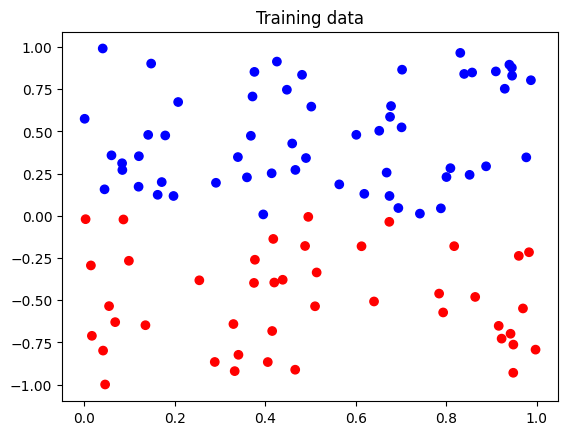

bias adjustment time:  1.0353450775146484
New bias:  -0.8795363027933236  Standard bias:  -0.0851651128344643
Best objective:  -82.42274971631898


In [8]:
N = 100
vectors = np.transpose([np.random.rand(N), 2*np.random.rand(N)-1])
labels = [2*int(y>0)-1 for x,y in vectors]
x, y = np.transpose(vectors)
plt.scatter(x,y, c=['blue' if labels[i] > 0 else 'red' for i in range(N)])
plt.title('Training data')
plt.show()
objectives, alphas, fs = qSVM(vectors, labels, base=2, num_encoding=4, penalty=False, kernel=gauss_kernel(1), solver='hybrid', shots=100, time_limit=5, samples=20, adjust_bias=True)
f = fs[0]
print('Best objective: ', objectives[0])

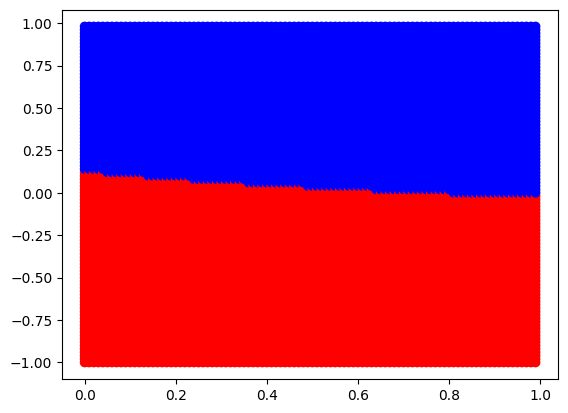

Kappa score =  0.9577538672230075
Accuracy score =  0.9789


In [9]:
M = 100
x, y = (np.array([[i]*M for i in range(M)])/M).flatten(), 2*np.array(list(range(M))*M)/M - 1
plt.scatter(x,y, c=['blue' if f((x[i],y[i])) > 0 else 'red' if f((x[i],y[i])) < 0 else 'black 'for i in range(M*M)])
plt.show()
print('Kappa score = ', kappa(f, [(x[i],y[i]) for i in range(len(x))], [2*int(y[i]>0)-1 for i in range(len(x))]))
print('Accuracy score = ', accuracy(f, [(x[i],y[i]) for i in range(len(x))], [2*int(y[i]>0)-1 for i in range(len(x))]))

Classical SVM Tests:

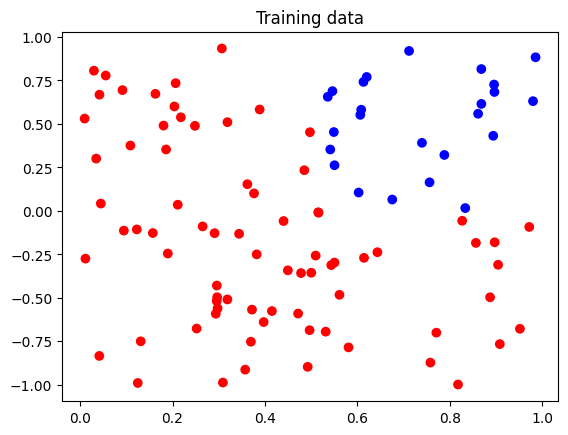

TypeError: Real-valued variables are currently not supported in quadratic interactions

In [3]:
N = 100
C = 10
gamma = 1e-1
vectors = np.transpose([np.random.rand(N), 2*np.random.rand(N)-1])
labels = [2*int(y>0 and x>0.5)-1 for x,y in vectors]
x, y = np.transpose(vectors)
plt.scatter(x,y, c=['blue' if labels[i] > 0 else 'red' for i in range(N)])
plt.title('Training data')
plt.show()
c_objectives, c_alphas, gs = cSVM(vectors, labels, C, kernel=gauss_kernel(gamma), solver='hybrid', time_limit=5, samples=20)
g = gs[0]

In [10]:
M = 40
x, y = (np.array([[i]*M for i in range(M)])/M).flatten(), 2*np.array(list(range(M))*M)/M - 1
plt.scatter(x,y, c=['blue' if g((x[i],y[i])) > 0 else 'red' if g((x[i],y[i])) < 0 else 'black' for i in range(M*M)])
plt.show()

NameError: name 'g' is not defined